## 1 Setup BART
This notebook is designed to run on a local system. It uses the python kernel, however, almost all commands use the `%%bash` cell magic to be executed in a `bash` subshell.

We will use BART version 0.9.00. In particular, we will take advantage of the newly added looping feature. For more information check the announcement on our [mailing list](https://lists.eecs.berkeley.edu/sympa/arc/mrirecon/2023-12/msg00000.html).


This version has been archived at CERN as:  

BART: version 0.9.00 (2023) DOI:10.5281/zenodo.10277939

### 1.1 Local Usage
- Install bart from its [github repository](https://github.com/mrirecon/bart)
- Set the `BART_TOOLBOX_PATH` to the BART directory and add it to the `PATH`

```bash
export BART_TOOLBOX_PATH=/path/to/bart  
export PATH=$BART_TOOLBOX_PATH:$PATH
```

Although the simplest way to call the BART CLI tools is from a terminal, there are also wrapper functions that allow the tools to be used from Matlab and Python. These are located under the `$BART_TOOLBOX_PATH/matlab` and `$BART_TOOLBOX_PATH/python` directories.

We will also use the [CFL viewer](https://github.com/mrirecon/view). Install it locally after configuring BART

In [1]:
import os
os.environ['DEMO'] = '1'
os.environ['DEMO_INSTALL'] = '0'

### 1.2 Clone and compile BART v0.9.00
We clone BART into the current working directory of this notebook and delete any previous installation in this directory.

In [2]:
%%bash

# Clone Bart
if [ 1 -eq $DEMO_INSTALL ]; then

    [ -d bart ] && rm -r bart
    git clone https://github.com/mrirecon/bart/ bart &> /dev/null

    cd bart

    make -j32 &> /dev/null
else
    echo skipped .. DEMO_INSTALL=$DEMO_INSTALL
fi

skipped .. DEMO_INSTALL=0


### 1.3 Add BART to PATH variable

We add the BART directory to the PATH variable and include the python wrapper for reading *.cfl files:

In [3]:
import os
import sys

os.environ['BART_TOOLBOX_PATH']=os.getcwd()+"/bart/"
os.environ['PATH'] = os.environ['BART_TOOLBOX_PATH'] + ":" + os.environ['PATH']
sys.path.append(os.environ['BART_TOOLBOX_PATH'] + "/python/")
os.environ['DEBUG_LEVEL'] = '2'
os.environ['BART_DEBUG_LEVEL'] = '2'

Check BART setup:

In [4]:
%%bash

echo "# The BART used in this notebook:"
which bart
echo "# BART version: "
bart version

# The BART used in this notebook:
/home/jpfitzer/bart-0.9.00/bart
# BART version: 
v0.9.00


### 1.4 Install Interactive CFL Viewer


In [5]:
%%bash

# Clone View
if [ 1 -eq $DEMO_INSTALL ]; then

    [ -d view ] && rm -r view
    git clone https://github.com/mrirecon/view/ view &> /dev/null

    cd view

    make &> /dev/null

else
    echo skipped .. DEMO_INSTALL=$DEMO_INSTALL
fi

skipped .. DEMO_INSTALL=0


In [6]:
os.environ['VIEW_TOOLBOX_PATH']=os.getcwd()+"/view/"
os.environ['PATH'] = os.environ['VIEW_TOOLBOX_PATH'] + ":" + os.environ['PATH']

Check view setup:

In [7]:
%%bash

echo "# The BART viewer used in this notebook:"
which view

# The BART viewer used in this notebook:
/usr/bin/view


### 1.5 Python Data Writer

In [151]:
# Copyright 2013-2015. The Regents of the University of California.
# Copyright 2021. Uecker Lab. University Center Göttingen.
# All rights reserved. Use of this source code is governed by
# a BSD-style license which can be found in the LICENSE file.
#
# Authors:
# 2013 Martin Uecker <uecker@eecs.berkeley.edu>
# 2015 Jonathan Tamir <jtamir@eecs.berkeley.edu>

from __future__ import print_function
from __future__ import with_statement

import numpy as np
import mmap
import os

from IPython.display import Image


def readcfl(name):
    # get dims from .hdr
    with open(name + ".hdr", "rt") as h:
        h.readline() # skip
        l = h.readline()
    dims = [int(i) for i in l.split()]

    # remove singleton dimensions from the end
    n = np.prod(dims)
    dims_prod = np.cumprod(dims)
    dims = dims[:np.searchsorted(dims_prod, n)+1]

    # load data and reshape into dims
    with open(name + ".cfl", "rb") as d:
        a = np.fromfile(d, dtype=np.complex64, count=n);
    return a.reshape(dims, order='F') # column-major

def readmulticfl(name):
    # get dims from .hdr
    with open(name + ".hdr", "rt") as h:
        lines = h.read().splitlines()

    index_dim = 1 + lines.index('# Dimensions')
    total_size = int(lines[index_dim])
    index_sizes = 1 + lines.index('# SizesDimensions')
    sizes = [int(i) for i in lines[index_sizes].split()]
    index_dims = 1 + lines.index('# MultiDimensions')

    with open(name + ".cfl", "rb") as d:
        a = np.fromfile(d, dtype=np.complex64, count=total_size)

    offset = 0
    result = []
    for i in range(len(sizes)):
        dims = ([int(i) for i in lines[index_dims + i].split()])
        n = np.prod(dims)
        result.append(a[offset:offset+n].reshape(dims, order='F'))
        offset += n

    if total_size != offset:
        print("Error")

    return result


def writecfl(name, array):
    with open(name + ".hdr", "wt") as h:
        h.write('# Dimensions\n')
        for i in (array.shape):
                h.write("%d " % i)
        h.write('\n')

    size = np.prod(array.shape) * np.dtype(np.complex64).itemsize

    with open(name + ".cfl", "a+b") as d:
        os.ftruncate(d.fileno(), size)
        mm = mmap.mmap(d.fileno(), size, flags=mmap.MAP_SHARED, prot=mmap.PROT_WRITE)
        if array.dtype != np.complex64:
            array = array.astype(np.complex64)
        mm.write(np.ascontiguousarray(array.T))
        mm.close()
        #with mmap.mmap(d.fileno(), size, flags=mmap.MAP_SHARED, prot=mmap.PROT_WRITE) as mm:
        #    mm.write(array.astype(np.complex64).tobytes(order='F'))

def writemulticfl(name, arrays):
    size = 0
    dims = []

    for array in arrays:
        size += array.size
        dims.append(array.shape)

    with open(name + ".hdr", "wt") as h:
        h.write('# Dimensions\n')
        h.write("%d\n" % size)

        h.write('# SizesDimensions\n')
        for dim in dims:
            h.write("%d " % len(dim))
        h.write('\n')

        h.write('# MultiDimensions\n')
        for dim in dims:
            for i in dim:
                h.write("%d " % i)
            h.write('\n')
            
    size = size * np.dtype(np.complex64).itemsize

    with open(name + ".cfl", "a+b") as d:
        os.ftruncate(d.fileno(), size)
        mm = mmap.mmap(d.fileno(), size, flags=mmap.MAP_SHARED, prot=mmap.PROT_WRITE)
        for array in arrays:
            if array.dtype != np.complex64:
                array = array.astype(np.complex64)
            mm.write(np.ascontiguousarray(array.T))
        mm.close()


## 2. Reading in the data

In [9]:
import scipy.io as sio

rawName = 'T2_CPMG.mat'
mat_data_0=sio.loadmat(rawName)

# Format: sampled, # kSpace [kRd, kPh, kSl, kSpace_echo_1, kSpace_echo_2, ..., kSpace_echo_nETL] (102400, 23)
# So the first three are the coordinates of the kspace, and the rest are the echoes

kSpaces3D = mat_data_0['kSpaces3D']
# self.mapVals['sampled'] = np.concatenate((kRD, kPH, kSL, dataAll_sampled), axis=1)

# nReadout, nPhase, nSlice
nPoints = (80, 80, 16)

echo_train_length = mat_data_0['kSpaces3D'].shape[1] - 3 # Because the first 3 are kRD, kPH, kSL -> should give 20
print(f"Echo train length: {echo_train_length}")

echo_spacing = mat_data_0['echoSpacing'][0][0]
print(f"Echo spacing: {echo_spacing} ms")

k_readout = kSpaces3D[:, 0]
k_phase = kSpaces3D[:, 1]
k_slice = kSpaces3D[:, 2]

# The rest of the data is the echoes
echos = kSpaces3D[:, 3:]

# Reshape the kspace data for bart
kSpace = echos.reshape(nPoints[2], nPoints[1], nPoints[0], echo_train_length)

print(kSpace.shape)

Echo train length: 20
Echo spacing: 10 ms
(16, 80, 80, 20)


In [208]:
# Write the cfl file
cfl = writecfl('data/kSpace', kSpace)

### 2.1 Data Exploration

In [209]:
%%bash

echo "ksp:"
bart show -m data/kSpace

DIM_X=80
DIM_Y=80
DIM_Z=16

ksp:
Type: complex float
Dimensions: 16
AoD:	16	80	80	20	1	1	1	1	1	1	1	1	1	1	1	1


### 2.2 FFT

We have three dimensional data so we perform the fft along the first three dimension. 

In [210]:
%%bash

bart fft -i $(bart bitmask 0 1 2) data/kSpace data/fft

In [211]:
%%bash

# view data/fft

In [212]:
%%bash

# Put the echos on the fifth dimension:
bart transpose 3 5 data/fft data/fft_transposed
# Put the slices on the correct dimension
bart transpose 0 2 data/fft_transposed data/fft_transposed

In [213]:
%%bash

echo "fft_transposed:"
bart show -m data/fft_transposed

fft_transposed:
Type: complex float
Dimensions: 16
AoD:	80	80	16	1	1	20	1	1	1	1	1	1	1	1	1	1


In [214]:
%%bash
# Create the echotimes file:
bart vec 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 data/echo_times
bart scale 0.001 data/echo_times data/echo_times_scaled
# Move the echo_times to the correct dimension:
bart transpose 0 5 data/echo_times_scaled data/echo_times_final

In [215]:
%%bash
bart mobafit -h

Usage: mobafit [-T] [-I] [-L] [-G] [-D] [-m d] [-a] [-i d] [-g] [-B <file>] [--init [f:]*f] [--scale [f:]*f] [--min-flag d] [--max-flag d] [--max-mag-flag d] [--min [f:]*f] [--max [f:]*f] <enc> <echo/contrast images> [<coefficients>] 

Pixel-wise fitting of physical signal models.

-T                      TSE
-I                      Inversion Recovery: f(M0, R1, c) =  M0 * (1 - exp(-t * R1 + c))
-L                      Inversion Recovery Look-Locker
-G                      MGRE
-D                      diffusion
-m model                Select the MGRE model from enum { WF = 0, WFR2S, WF2R2S, R2S, PHASEDIFF } [default: WFR2S]
-a                      fit magnitude of signal model to data
-i iter                 Number of IRGNM steps
-g                      use gpu
-B file                 temporal (or other) basis
--init [f:]*f           Initial values of parameters in model-based reconstruction
--scale [f:]*f          Scaling
--min-flag flags        Apply minimum constraint on selected ma

In [216]:
%%bash
# Fit the model:
bart mobafit -T data/echo_times_final data/fft_transposed data/fit

In [217]:
%%bash
# Now some values will be very large so we can apply a threshold to obtain a mask
MAX_T2=1000

bart threshold -M $MAX_T2 data/fit data/mask

In [218]:
%%bash
# Multiply the fit with the mask
bart fmac data/fit data/mask data/fit_mask

In [219]:
%%bash
# Select slice
bart slice 6 1 data/fit_mask data/R2_map

In [220]:
%%bash
# Invert the data to get T2
bart invert data/R2_map data/T2_map 

## 3.1 Undersampling Poisson ky - kz

In [221]:
%%bash
ACC_Y=2
ACC_Z=2

bart poisson -Y 80 -Z 16 -y $ACC_Y -z $ACC_Z -C 16 -e data/vd_mask

bart show -m data/vd_mask

bart transpose 0 2 data/kSpace data/kSpace_transposed

bart show -m data/kSpace_transposed

points: 448, grid size: 80x16x(pi/4) = 1005 (R = 2.243995)
Type: complex float
Dimensions: 16
AoD:	1	80	16	1	1	1	1	1	1	1	1	1	1	1	1	1
Type: complex float
Dimensions: 16
AoD:	80	80	16	20	1	1	1	1	1	1	1	1	1	1	1	1


In [222]:
!bart transpose 1 2 data/vd_mask data/img
!bart toimg -w 1.0 data/img fig/vd_mask.png
Image("fig/vd_mask.png", width=1000)

Writing 1 image(s)...done.


In [223]:
%%bash
bart fmac data/vd_mask data/kSpace_transposed data/kSpace_vd

In [224]:
%%bash
# For nlinv the echos can't be in the coil dimension (3)
bart transpose 3 5 data/kSpace_vd data/kSpace_vd_transposed
# The scaling seems to help
bart nlinv -i 30 -x 80:80:16 -S data/kSpace_vd_transposed data/nlinv_vd

Scaling: 0.349166


In [225]:
%%bash 
bart pattern data/kSpace_vd data/pattern_vd

In [226]:
%%bash
# Fit the model:
bart mobafit -T data/echo_times_final data/nlinv_vd data/fit_vd

# Now some values will be very large so we can apply a threshold to obtain a mask
MAX_T2=1000

bart threshold -M $MAX_T2 data/fit_vd data/mask_vd

# Multiply the fit with the mask
bart fmac data/fit_vd data/mask_vd data/fit_mask_vd

# Select slice
bart slice 6 1 data/fit_mask_vd data/R2_map_vd

# Invert the data to get T2
bart invert data/R2_map_vd data/T2_map_vd 

### 3.2 Undersampling Poisson-Disc in-plane
This isn't useful for a real sequence because then you undersample in readout direction.

In [227]:
%%bash

ACC_Y=2
ACC_Z=2

bart poisson -Y 80 -Z 80 -y $ACC_Y -z $ACC_Z -C 16 -e data/ip_mask

bart squeeze data/ip_mask data/ip_mask

bart show -m data/ip_mask

bart show -m data/kSpace_transposed

bart fmac data/ip_mask data/kSpace_transposed data/kSpace_ip

# For nlinv the echos can't be in the coil dimension (3)
bart transpose 3 5 data/kSpace_ip data/kSpace_ip_transposed

bart nlinv -i 30 -x 80:80:16 -S data/kSpace_ip_transposed data/nlinv_ip
# bart fft -i $(bart bitmask 0 1 2) data/kSpace_ip data/fft_ip

bart pattern data/kSpace_ip data/pattern_ip

# bart transpose 3 5 data/fft_ip data/fft_ip_transposed

# Fit the model:
bart mobafit -T data/echo_times_final data/nlinv_ip data/fit_ip

# Now some values will be very large so we can apply a threshold to obtain a mask
MAX_T2=1000

bart threshold -M $MAX_T2 data/fit_ip data/mask_ip

# Multiply the fit with the mask
bart fmac data/fit_ip data/mask_ip data/fit_mask_ip

# Select slice
bart slice 6 1 data/fit_mask_ip data/R2_map_ip

# Invert the data to get T2
bart invert data/R2_map_ip data/T2_map_ip 

points: 1450, grid size: 80x80x(pi/4) = 5026 (R = 3.466585)
Type: complex float
Dimensions: 16
AoD:	80	80	1	1	1	1	1	1	1	1	1	1	1	1	1	1
Type: complex float
Dimensions: 16
AoD:	80	80	16	20	1	1	1	1	1	1	1	1	1	1	1	1
Scaling: 0.351537


Writing 1 image(s)...done.


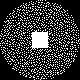

In [228]:
!bart transpose 1 2 data/ip_mask data/img
!bart toimg -w 1.0 data/img fig/ip_mask.png
Image("fig/ip_mask.png", width=500)

## 3.3 Uniform Undersampling
Using bart upat - same pattern for every echo.

In [229]:
%%bash
ACC_Y=2
ACC_Z=2
CENTER_SIZE=8

bart upat -Y 80 -Z 16 -y $ACC_Y -z $ACC_Z -c $CENTER_SIZE data/upat

In [230]:
%%bash
bart fmac data/upat data/kSpace_transposed data/kSpace_upat

# For nlinv the echos can't be in the coil dimension (3)
bart transpose 3 5 data/kSpace_upat data/kSpace_upat_transposed

bart nlinv -i 30 -x 80:80:16 -S data/kSpace_upat_transposed data/nlinv_upat
# bart fft -i $(bart bitmask 0 1 2) data/kSpace_upat data/fft_upat

# bart transpose 3 5 data/fft_upat data/fft_upat_transposed

# Fit the model:
bart mobafit -T data/echo_times_final data/nlinv_upat data/fit_upat

# Now some values will be very large so we can apply a threshold to obtain a mask
MAX_T2=1000

bart threshold -M $MAX_T2 data/fit_upat data/mask_upat

# Multiply the fit with the mask
bart fmac data/fit_upat data/mask_upat data/fit_mask_upat

# Select slice
bart slice 6 1 data/fit_mask_upat data/R2_map_upat

# Invert the data to get T2
bart invert data/R2_map_upat data/T2_map_upat 

Scaling: 0.349421


In [231]:
!bart transpose 1 2 data/upat data/img
!bart toimg -w 1.0 data/img fig/upat_mask.png
Image("fig/upat_mask.png", width=1000)

Writing 1 image(s)...done.


### 3.3.1 Uniform Undersampling
With varying patterns along the echos

In [246]:
%%bash
# Parameters
R=2        # Undersampling factor 4 leads to bad results
Y=80       # Dimension Y
Z=16       # Dimension Z
N_ECHO=20  # Number of ECHO shifts
CENTER_SIZE=16

# Create the center 
bart ones 2 $CENTER_SIZE $CENTER_SIZE data/mask_center
bart transpose 0 2 data/mask_center data/mask_center

# Zero-pad the second (index 1) dimension to the full k-space dimension 
bart resize -c 1 $Y 2 $Z data/mask_center data/mask_full

# Create pattern with undersampling in phase direction by R=4
bart upat -Y $Y -Z $Z -y $R -z 1 -c 1 data/upat

# Initialize the final combined pattern file
bart saxpy 1 data/mask_full data/upat data/upat_combined

# Loop over N_ECHO times to apply shifts and join them
for ((i=1; i<N_ECHO; i++))
do
  # Apply a circular shift of one along the phase direction
  bart circshift 1 $i data/upat data/upat_shifted

  # Combine the center mask and the 
  bart saxpy 1 data/mask_full data/upat_shifted data/tmp

  # Join the shifted pattern along the 5th dimension 
  bart join 5 data/upat_combined data/tmp data/upat_combined
done

# Threshold because some values can be 2 after saxpy
bart threshold -B 0.1 data/upat_combined data/upat_combined

echo "Pattern creation completed. Output file: upat_combined"

Pattern creation completed. Output file: upat_combined


In [247]:
%%bash
# For nlinv the echos can't be in the coil dimension (3) also to make it work with the upat_combined
bart transpose 3 5 data/kSpace_transposed data/kSpace_upat_combined_transposed

bart fmac data/upat_combined data/kSpace_upat_combined_transposed data/kSpace_upat_combined

# Compute pattern (just to check)
bart pattern data/kSpace_upat_combined data/calc_pattern

bart nlinv -i 30 -x 80:80:16 -S data/kSpace_upat_combined data/nlinv_upat_combined
# bart fft -i $(bart bitmask 0 1 2) data/kSpace_upat data/fft_upat

# bart transpose 3 5 data/fft_upat data/fft_upat_transposed

# Fit the model:
bart mobafit -T data/echo_times_final data/nlinv_upat_combined data/fit_upat_combined

# Now some values will be very large so we can apply a threshold to obtain a mask
MAX_T2=1000

bart threshold -M $MAX_T2 data/fit_upat_combined data/mask_upat_combined

# Multiply the fit with the mask
bart fmac data/fit_upat_combined data/mask_upat_combined data/fit_mask_upat_combined

# Select slice
bart slice 6 1 data/fit_mask_upat_combined data/R2_map_upat_combined

# Invert the data to get T2
bart invert data/R2_map_upat_combined data/T2_map_upat_combined

Scaling: 0.347030


In [248]:
!bart transpose 1 2 data/upat_combined data/img
!bart slice 5 1 data/img data/img
!bart toimg -w 1.0 data/img fig/upat_combined_mask.png
Image("fig/upat_combined_mask.png", width=1000)

Writing 1 image(s)...done.


### 3.3.1 Uniform Undersampling (in-plane)
With varying patterns along the echos in-plane (kx ky)

In [238]:
%%bash
# Parameters
R=4        # Undersampling factor
Y=80       # Dimension Y
X=80       # Dimension Z
N_ECHO=20  # Number of ECHO shifts
CENTER_SIZE=16

# Create the center 
bart ones 2 $Y $CENTER_SIZE data/mask_center

# Zero-pad the second (index 1) dimension to the full k-space dimension 
bart resize -c 1 $Y data/mask_center data/mask_full

# Now the mask needs to be in x-y plane
#bart transpose 1 2 data/mask_full data/mask_full
#bart transpose 0 1 data/mask_full data/mask_full

# Create pattern with undersampling in phase direction by R=4
bart upat -Y $Y -Z $X -y $R -z 1 -c 1 data/upat

# Transpose this so it fits the bart dataformat
bart transpose 0 2 data/upat data/upat

# Initialize the final combined pattern file
bart saxpy 1 data/mask_full data/upat data/upat_combined_ip

# Loop over N_ECHO times to apply shifts and join them
for ((i=1; i<N_ECHO; i++))
do
  # Apply a circular shift of one along the phase direction
  bart circshift 1 $i data/upat data/upat_shifted

  # Combine the center mask and the 
  bart saxpy 1 data/mask_full data/upat_shifted data/tmp

  # Join the shifted pattern along the 5th dimension 
  bart join 5 data/upat_combined data/tmp data/upat_combined_ip
done

bart threshold -B 0.1 data/upat_combined data/upat_combined_ip

echo "Pattern creation completed. Output file: upat_combined"



Pattern creation completed. Output file: upat_combined


Writing 1 image(s)...done.


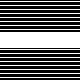

In [240]:
!bart transpose 0 1 data/upat_combined_ip data/img
!bart slice 5 1 data/img data/img
!bart toimg -w 1.0 data/img fig/upat_combined_mask_ip.png
Image("fig/upat_combined_mask_ip.png", width=500)

In [245]:
%%bash
# For nlinv the echos can't be in the coil dimension (3) also to make it work with the upat_combined
bart transpose 3 5 data/kSpace_transposed data/kSpace_upat_combined_transposed

bart fmac data/upat_combined data/kSpace_upat_combined_transposed data/kSpace_upat_combined_ip

# Compute pattern (just to check)
bart pattern data/kSpace_upat_combined_ip data/calc_pattern_ip

bart nlinv -i 30 -x 80:80:16 -S data/kSpace_upat_combined_ip data/nlinv_upat_combined_ip
# bart fft -i $(bart bitmask 0 1 2) data/kSpace_upat data/fft_upat

# bart transpose 3 5 data/fft_upat data/fft_upat_transposed

# Fit the model:
bart mobafit -T data/echo_times_final data/nlinv_upat_combined_ip data/fit_upat_combined_ip

# Now some values will be very large so we can apply a threshold to obtain a mask
MAX_T2=1000

bart threshold -M $MAX_T2 data/fit_upat_combined_ip data/mask_upat_combined_ip

# Multiply the fit with the mask
bart fmac data/fit_upat_combined_ip data/mask_upat_combined_ip data/fit_mask_upat_combined_ip

# Select slice
bart slice 6 1 data/fit_mask_upat_combined_ip data/R2_map_upat_combined_ip

# Invert the data to get T2
bart invert data/R2_map_upat_combined_ip data/T2_map_upat_combined_ip

Scaling: 0.348982
